In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import gc
import psutil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import warnings
from enum import Enum

<h2> CliffWalking Grid </h2>

<b>Problem Credit:</b> Alberta Machine Learning Institute <br/><br/>
The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task; termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination.
<img src="Cliff-GridWorld.png" style="height:300px">

<b> TD(0) Algorithm for Policy Iteration (Uniform Random)

In [7]:
class policy(Enum):
    LEFT, RIGHT, UP, DOWN = 1, 2, 3, 4
pol = {(r, c):{policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25} for r in range(3)
         for c in range(12)}
pol[(3,0)] = {policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25}
def get_start():
    return (3,0)
def is_terminal(state):
    return (state[0]==3) and (state[1]==11)

In [8]:
def get_move(state, pol):
    action, newstate, reward = np.random.uniform(low=0, high=1), None, None
    if action<pol[state][policy.LEFT]:
        action=policy.LEFT
        newstate, reward = (state[0], state[1]-1), -1
    elif action<(pol[state][policy.LEFT]+pol[state][policy.RIGHT]):
        action=policy.RIGHT
        newstate, reward = (state[0], state[1]+1), -1
    elif action<(1-pol[state][policy.DOWN]):
        action=policy.UP
        newstate, reward = (state[0]-1, state[1]), -1
    else:
        action=policy.DOWN
        newstate, reward = (state[0]+1, state[1]),-1
    if (newstate[0]<0) or (newstate[0]>3) or (newstate[1]<0) or (newstate[1]>11):
        newstate, reward = state, 0
    if (newstate[0]==3) and (newstate[1]!=0) and (newstate[1]!=11):
        newstate, reward = (3,0), -100
    if is_terminal(newstate):
        reward = 200
    return action, reward, newstate

In [9]:
def one_episode_TD0(pol, stepsize, values):
    state=get_start()
    newvalues = values.copy()
    while (not is_terminal(state)):
        action, reward, newstate = get_move(state, pol)
        newvalues[state[0], state[1]] += stepsize*(reward+newvalues[newstate[0], newstate[1]]-
                                                newvalues[state[0], state[1]])
        state = newstate
    return newvalues

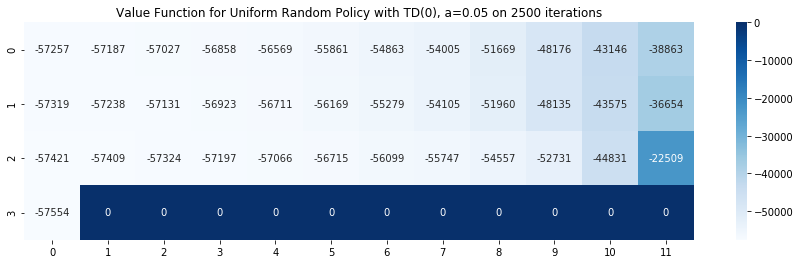

In [10]:
stepsize = 0.05
iterations = 2500
values = np.zeros((4,12))
for i in range(iterations):
    values = one_episode_TD0(pol, stepsize, values)
plt.figure(figsize=(15,4))
sns.heatmap(values, cmap="Blues", annot=True, fmt='.0f')
plt.title("Value Function for Uniform Random Policy with TD(0), a="+str(stepsize)+" on "
          +str(iterations)+" iterations")
plt.show()

<b>Epsilon-Greedy SARSA Algorithm for Value Iteration

In [12]:
def one_episode_epsilon_sarsa(stepsize, epsilon, actdict, pol):
    state1 = get_start()
    action1, reward1, state2 = get_move(state1, pol)
    def action_policy_updater(s, a, r, nvl):
        actdict[s][a] += stepsize*(r+nvl-actdict[s][a])
        bestmove = max(actdict[s], key=actdict[s].get)
        numbestmove = 0
        for i in range(1,5):
            if actdict[s][policy(i)]==actdict[s][bestmove]:
                numbestmove+=1;
        for i in range(1,5):
            if actdict[s][policy(i)]==actdict[s][bestmove]:
                pol[s][policy(i)] = (1-(4-numbestmove)/4*epsilon)/numbestmove
            else:
                pol[s][policy(i)] = epsilon/4
    while (not is_terminal(state2)):
        action2, reward2, tmpstate = get_move(state2, pol)
        action_policy_updater(state1, action1, reward1, actdict[state2][action2])
        state1, action1, reward1, state2 = state2, action2, reward2, tmpstate
    action_policy_updater(state1, action1, reward1, 0)

In [16]:
def epsilon_sarsa_simulation(stepsize, epsilon, iterations):
    actdict = {(r, c):{policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0} for r in range(3)
         for c in range(12)}
    actdict[(3,0)] = {policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0}
    pol = {(r, c):{policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25} for r in range(3)
         for c in range(12)}
    pol[(3,0)] = {policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25}
    for _ in range(iterations):
        one_episode_epsilon_sarsa(stepsize, epsilon, actdict, pol)
    return actdict, pol

In [23]:
%time actdict, pol = epsilon_sarsa_simulation(0.01, 0.2, 10000)

CPU times: user 7.65 s, sys: 12.5 ms, total: 7.66 s
Wall time: 7.67 s


In [24]:
actdict

{(0, 0): {<policy.LEFT: 1>: 0.02834069895439051,
  <policy.RIGHT: 2>: -2.54146972297026,
  <policy.UP: 3>: -0.6972132566262174,
  <policy.DOWN: 4>: 40.68449710801271},
 (0, 1): {<policy.LEFT: 1>: -1.1753841419738207,
  <policy.RIGHT: 2>: 38.295547044144534,
  <policy.UP: 3>: -0.6482845468812263,
  <policy.DOWN: 4>: 3.883810800318213},
 (0, 2): {<policy.LEFT: 1>: 3.6323159923277877,
  <policy.RIGHT: 2>: 3.870856814267675,
  <policy.UP: 3>: 8.115975857668511,
  <policy.DOWN: 4>: 53.129969853259205},
 (0, 3): {<policy.LEFT: 1>: 3.2668193878108047,
  <policy.RIGHT: 2>: 45.26706831020106,
  <policy.UP: 3>: 2.4001441990239405,
  <policy.DOWN: 4>: 10.140281358800943},
 (0, 4): {<policy.LEFT: 1>: 8.129992836470421,
  <policy.RIGHT: 2>: 59.319900769537455,
  <policy.UP: 3>: 16.20101849253588,
  <policy.DOWN: 4>: 20.87101263642586},
 (0, 5): {<policy.LEFT: 1>: 11.340770659044388,
  <policy.RIGHT: 2>: 21.937849685825462,
  <policy.UP: 3>: 28.574541747631798,
  <policy.DOWN: 4>: 69.00531510398497}

In [51]:
pol = {(r, c):{policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25} for r in range(3)
         for c in range(12)}
pol[(3,0)] = {policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25}

In [11]:
actdict

{(0, 0): {<policy.LEFT: 1>: 51.294675926387875,
  <policy.RIGHT: 2>: 49.02559131182763,
  <policy.UP: 3>: 45.92643561524439,
  <policy.DOWN: 4>: 74.08269182151416},
 (0, 1): {<policy.LEFT: 1>: 56.32933681717,
  <policy.RIGHT: 2>: 53.8157401727284,
  <policy.UP: 3>: 56.221984363936436,
  <policy.DOWN: 4>: 76.07817786285369},
 (0, 2): {<policy.LEFT: 1>: 51.6178472463605,
  <policy.RIGHT: 2>: 46.84656477087489,
  <policy.UP: 3>: 51.50053052908626,
  <policy.DOWN: 4>: 77.74023717944416},
 (0, 3): {<policy.LEFT: 1>: 51.00949523122907,
  <policy.RIGHT: 2>: 60.64853930223413,
  <policy.UP: 3>: 53.942484289660385,
  <policy.DOWN: 4>: 79.32037093504701},
 (0, 4): {<policy.LEFT: 1>: 46.727436741313795,
  <policy.RIGHT: 2>: 81.98101519245645,
  <policy.UP: 3>: 57.579076659616774,
  <policy.DOWN: 4>: 65.42491402251304},
 (0, 5): {<policy.LEFT: 1>: 65.48265555886665,
  <policy.RIGHT: 2>: 74.18814482272357,
  <policy.UP: 3>: 72.71683315243163,
  <policy.DOWN: 4>: 84.35713614400927},
 (0, 6): {<polic

In [24]:
policy(1)==max({policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0}, key={policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0}.get)

True